# Semana 9 Classificação

## Importação das bibliotecas

In [1]:
import functools
from math import sqrt

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import scipy.stats as sct
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.datasets import make_blobs, make_classification
from sklearn.decomposition import PCA
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree

In [2]:
# Algumas configurações para o matplotlib.
%matplotlib inline

from IPython.core.pylabtools import figsize


figsize(12, 12)

In [3]:
np.random.seed(1000)

In [4]:
def visualize_classifier(model, X, y, ax=None, cmap='rainbow'):
    ax = ax or plt.gca()
    
    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=cmap,
               clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    ax.axis('off')
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # Predict
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # Create a color plot with the results
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap=cmap, #clim=(y.min(), y.max()),
                           zorder=1)

    ax.set(xlim=xlim, ylim=ylim)



## Dados desbalanceados (SMOTE)

In [5]:
X_data, y_data = make_classification(n_samples=1000,
                                     n_features=10,
                                     n_informative=10,n_redundant=0,
                                     n_repeated=0,
                                     weights=(0.1, 0.9),
                                     n_clusters_per_class=1,
                                     class_sep=3.0)

imbalanced = pd.DataFrame(np.c_[X_data, y_data], columns=["X" + str(i) for i in range(1, 11)] + ["target"])

imbalanced.target = imbalanced.target.astype(bool)

In [6]:
imbalanced.iloc[:5, :-1]

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10
0,2.264019,-5.879977,-0.262661,1.137353,-1.635105,-2.531767,5.789418,-0.951279,2.643438,-0.831458
1,1.829764,-5.209499,2.999197,2.290076,-3.010978,-4.402686,0.908426,-3.332957,3.722355,0.615578
2,1.350631,-5.069955,3.869841,2.523473,-4.199743,-6.161144,0.800673,-1.716646,5.273588,2.746047
3,0.897472,-4.894522,1.861834,3.581587,-2.396599,-6.604574,2.122387,-2.099819,1.930993,1.464681
4,2.399397,-1.858286,5.391069,3.715560,-4.269411,-4.255609,0.762214,-3.168513,6.155921,4.429450


Por construção, existem muito mais dados da classe positiva do que da classe negativa (uma proporção 9:1):

In [7]:
imbalanced.target.value_counts()

True     894
False    106
Name: target, dtype: int64

Para visualizar os dados, que estão em $\mathbb{R}^{10}$, utilizamos PCA e os transformamos para $\mathbb{R}^{2}$:

In [8]:
pca = PCA(n_components=2)

pca.fit(imbalanced.drop(["target"], axis=1))

imbalanced_pca = pca.transform(imbalanced.drop(["target"], axis=1))

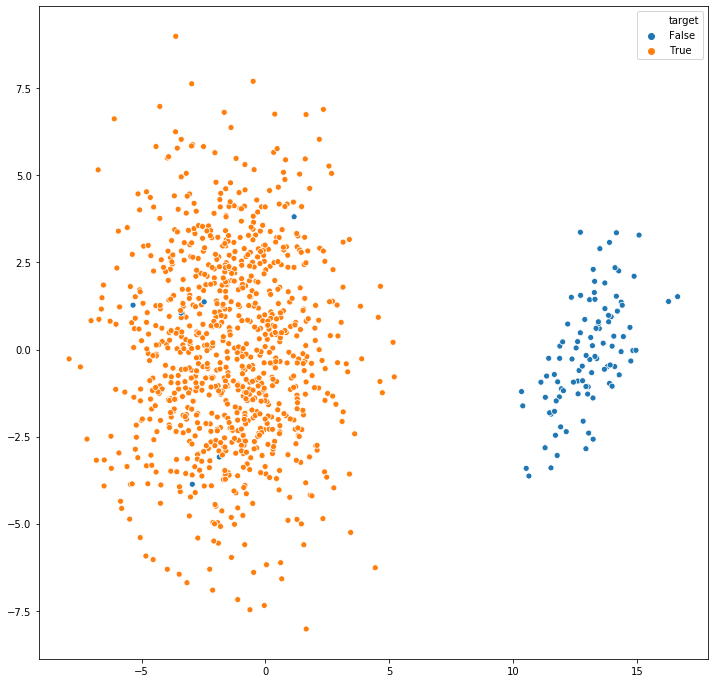

In [9]:
sns.scatterplot(imbalanced_pca[:, 0], imbalanced_pca[:, 1], hue=imbalanced.target);

Assim podemos ver claramente a maioria sendo da classe positiva (em laranja).

Utilizamos o SMOTE (do pacote `imblearn`) para reamostrar os dados da classe minoritária e assim balancear o _data set_:

In [10]:
smote = SMOTE(ratio="minority")

X_smote, y_smote = smote.fit_resample(imbalanced.iloc[:, :-1], imbalanced.target)

In [11]:
imbalanced_pca_smote = pca.transform(X_smote)

Agora podemos ver que existem mais dados da classe negativa (em azul) do que no _data set_ original:

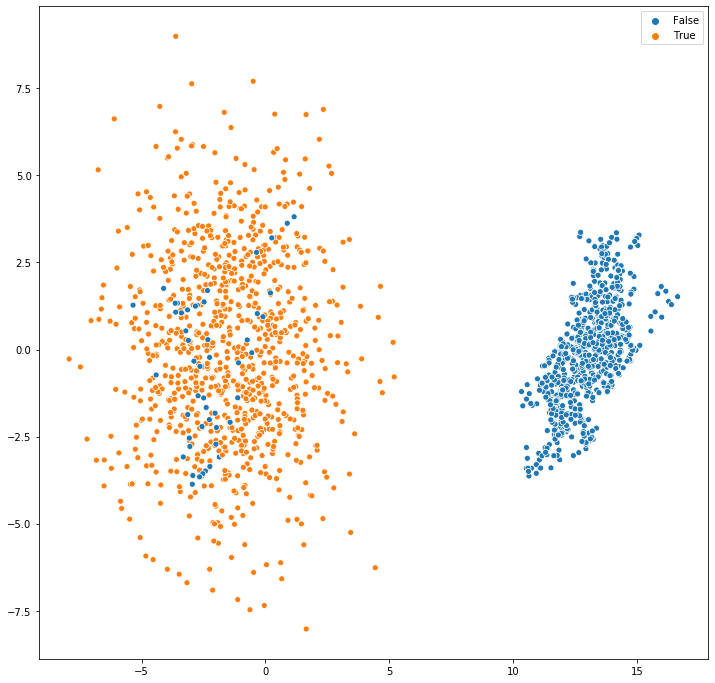

In [12]:
sns.scatterplot(x=imbalanced_pca_smote[:, 0], y=imbalanced_pca_smote[:, 1], hue=y_smote);

E a quantidade dados positivos e negativos se tornou igual:

In [13]:
sum(y_smote == True)/sum(y_smote == False)

1.0

## Criando _data set_ para classificação

Para os exemplos a seguir, vamos criar um _data set_ com 500 observações divididas em três classes:

In [14]:
X, y = make_blobs(n_samples=500, centers=3, cluster_std=2.0)

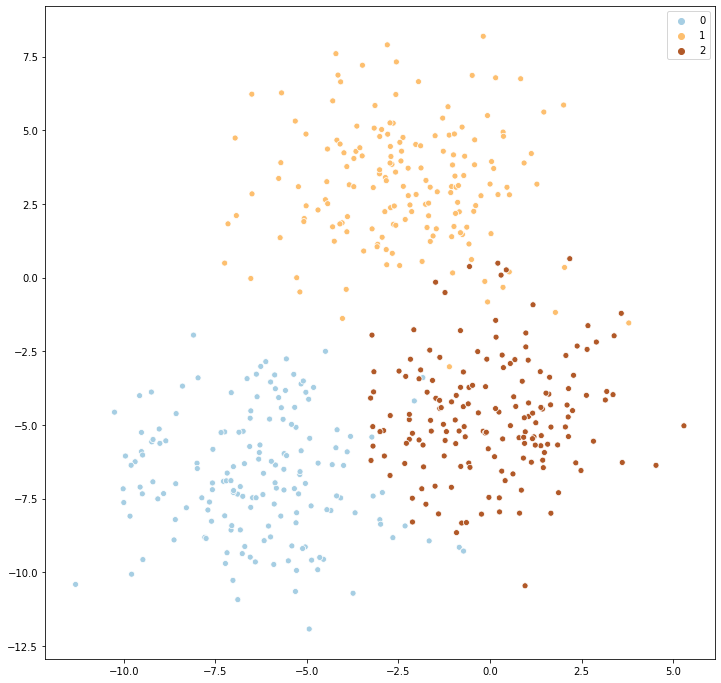

In [15]:
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, palette="Paired");

Para realizar o treinamento e teste dos modelos, vamos dividir o _data set_ criado em treinamento e teste numa razão de 4:1:

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X_train.shape

(400, 2)

## Regressão logística

In [17]:
logistic = LogisticRegression()

logistic.fit(X_train, y_train)

/Users/gabriel.bellon/.virtualenvs/codenation/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/gabriel.bellon/.virtualenvs/codenation/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

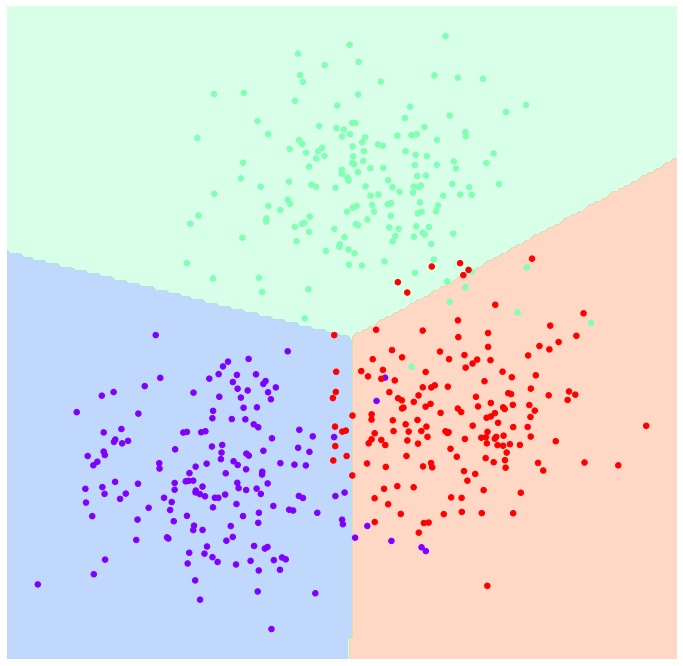

In [18]:
visualize_classifier(logistic, X, y)

Como a saída da regressão logística são probabilidades, é natural que o modelo tenha um método `predict_proba()` que nos retorne a probabilidade do dado de teste pertencer a cada uma das classes:

In [19]:
logistic.predict_proba([[-3, -2]])

array([[0.38683015, 0.362033  , 0.25113685]])

In [20]:
logistic.predict([[-3, -2]])

array([0])

A classe considerada como resposta é aquela que apresenta a maior probabilidade.

## $k$ _Nearest Neighbors_

In [21]:
knn = KNeighborsClassifier(n_neighbors=7)

knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=7, p=2,
                     weights='uniform')

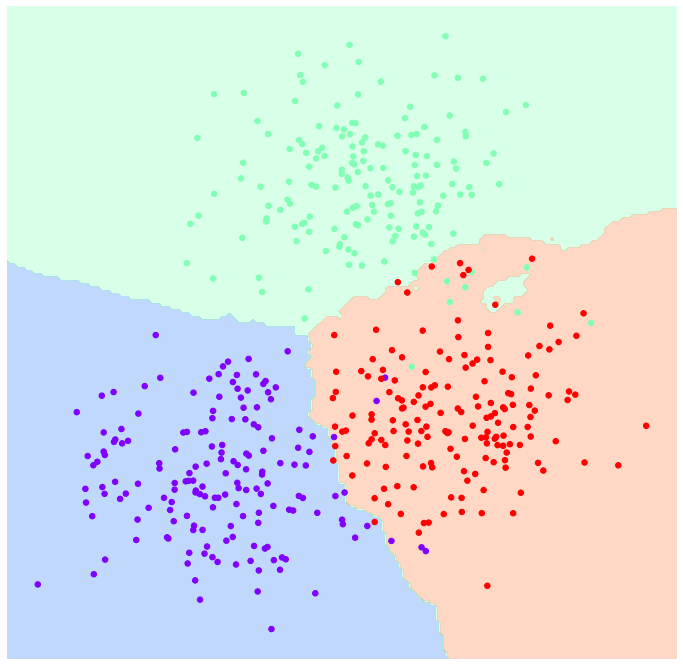

In [22]:
visualize_classifier(knn, X, y)

## Árvores de decisão

No exemplo abaixo, utilizamos o conjunto criado anteriormente para treinar uma árvore de decisão com profundidade máximo de 2.

In [23]:
decision_tree = DecisionTreeClassifier(max_depth=2)

decision_tree_fitted = decision_tree.fit(X_train, y_train)

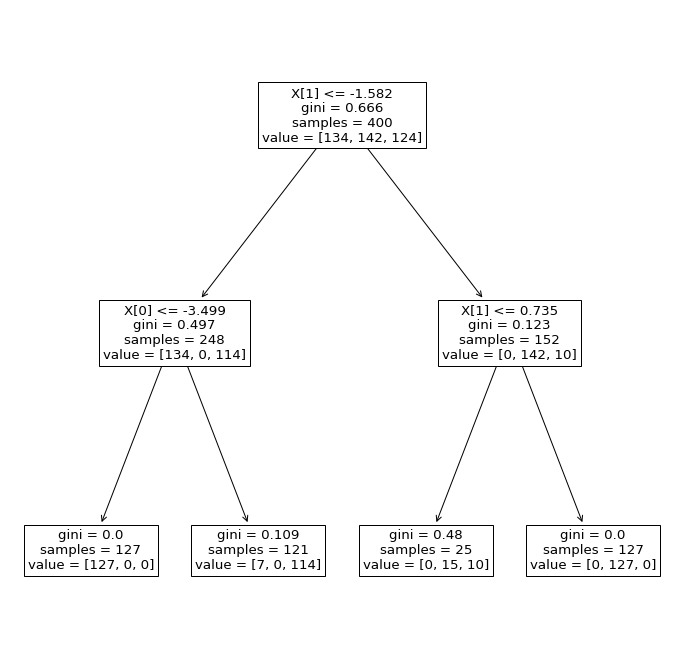

In [24]:
plot_tree(decision_tree_fitted);

Como podemos ver na árvore acima, a primeira folha tem índice de Gini igual a zero, o que significa que 100% dos dados que caíram nessa região durante o treinamento são todos da mesma classe. O mesmo acontece na última folha.

Abaixo verificamos as fronteiras de decisão da árvore criada:

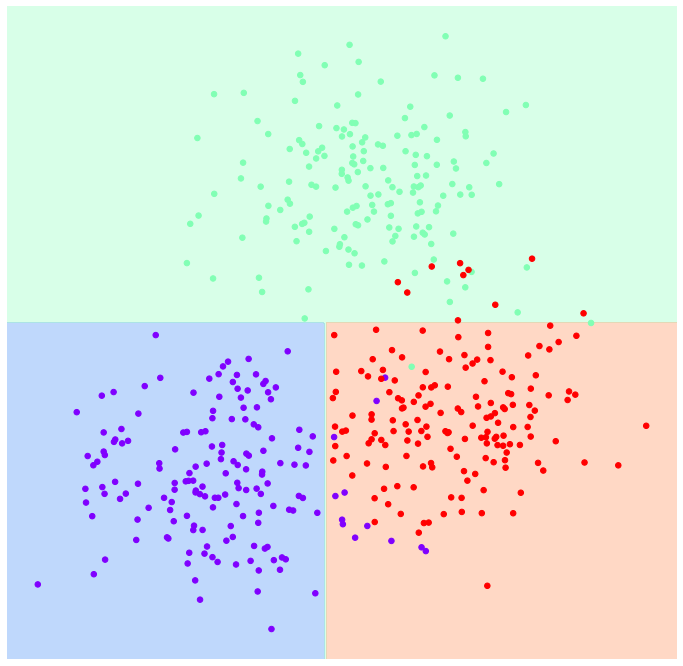

In [25]:
visualize_classifier(decision_tree, X, y);

Para prever em qual classe um dado de teste se encaixa, seguindo as regras da árvore de decisão, podemos utilizar o método `predict()`. Combinamos com o atributo `classes_` para identificar a classe exata:

In [26]:
print(f"(-6, -6): {decision_tree.classes_[decision_tree.predict([[-6, -6]])]}")
print(f"(-0, -6): {decision_tree.classes_[decision_tree.predict([[0, -6]])]}")
print(f"( 4,  6): {decision_tree.classes_[decision_tree.predict([[4, 6]])]}")

(-6, -6): [0]
(-0, -6): [2]
( 4,  6): [1]


Também é possível encontrar a probabilidade estimada do dado de teste se encaixar em qualquer uma das classes através do método `predict_proba()`:

In [27]:
decision_tree.predict_proba([[-4, -5]])

array([[1., 0., 0.]])

Árvores de decisão apresentam vantagens e desvantagens. Algumas vantagens:

* São fáceis de interpretar.
* Os dados não precisam ser pré-processados (normalização, padronização, nada disso).
* São não paramétricas, ou seja, não dependem de nenhuma suposição em relação aos dados.

Porém, também apresentam algumas desvantagens:

* Podem fazer _overfitting_ dos dados com certa facilidade.
* São muito suscetíveis a variações dos dados de treinamento.
* Não funcionam bem com _data sets_ desbalanceados.
* Dividem as regiões sempre de forma ortogonal.

## _Bagging_

Importante notar que _bagging_ funciona com qualquer modelo de classificação. Mas é especialmente útil e popular com árvores de decisão.

Um exemplo de _bagging_ com 300 árvores de decisão, onde em cada árvore são escolhidos 100 dados do conjunto de treinamento, é mostrado abaixo:

In [28]:
bagging = BaggingClassifier(DecisionTreeClassifier(), n_estimators=300, max_samples=100, bootstrap=True)

bagging.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None,
                                                        criterion='gini',
                                                        max_depth=None,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                                                        presort=False,
                                                        random_state=None,
                                                        splitter='best'),
    

As regiões encontradas pelo _ensemble_ final são mostradas abaixo. Note como as fronteiras de decisão são agora muito menos rígidas que aquelas encontradas por uma única árvore de decisão.

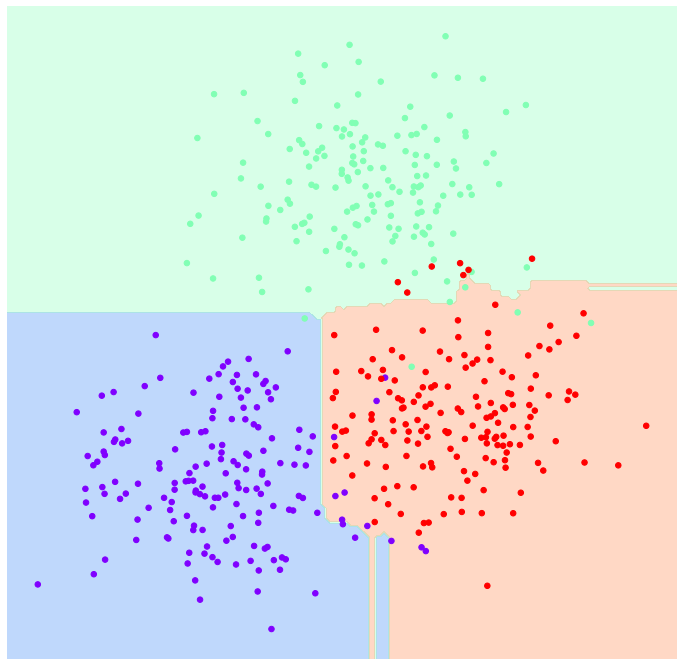

In [30]:
visualize_classifier(bagging, X, y);

Importante notar que ao fazermos _bagging_ (ou qualquer tipo de _ensemble_), abrimos mão da interpretabilidade do modelo. Enquanto uma árvore de decisão é um modelo altamente interpretável, um monte de árvores agindo ao mesmo tempo não é interpretável. Esse é um _tradeoff_ que temos que fazer entre interpretabilidade e desempenho.

## _Random forest_

In [31]:
random_forest = RandomForestClassifier(n_estimators=500)

random_forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

As regiões obtidas com _random forest_ são ainda mais flexíveis do que aquelas encontradas com _bagging_ simples:

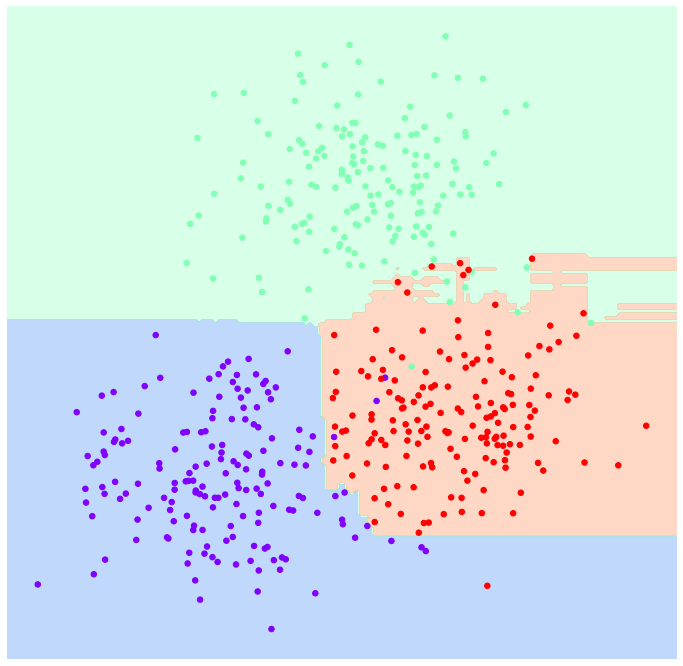

In [32]:
visualize_classifier(random_forest, X, y);

In [33]:
print(f"(-6, -6): {random_forest.classes_[random_forest.predict([[-6, -6]])]}")
print(f"(-0, -6): {random_forest.classes_[random_forest.predict([[0, -6]])]}")
print(f"( 4,  6): {random_forest.classes_[random_forest.predict([[4, 6]])]}")

(-6, -6): [0]
(-0, -6): [2]
( 4,  6): [1]


In [34]:
random_forest.predict_proba([[-4, -5]])

array([[0.874, 0.036, 0.09 ]])